In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import corner
pd.options.display.float_format = '{:.5f}'.format

## Q1+Q2

In [0]:
fifa_df=pd.read_csv("FIFA17_official_data.csv")
fifa_subset=fifa_df['Name', 'Age', 'Nationality', 'Overall',
       'Potential', 'Club', 'Value', 'Wage',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes',
       'Best Position', 'Best Overall Rating']

In [17]:
fifa_df

,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,...,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Best Position,Best Overall Rating
0,176580,L. Suárez,29,https://cdn.sofifa.com/players/176/580/17_60.png,Uruguay,https://cdn.sofifa.com/flags/uy.png,92,92,FC Barcelona,https://cdn.sofifa.com/teams/241/light_30.png,...,30.00000,45.00000,38.00000,27.00000,25.00000,31.00000,33.00000,37.00000,ST,88.00000
1,178518,R. Nainggolan,28,https://cdn.sofifa.com/players/178/518/17_60.png,Belgium,https://cdn.sofifa.com/flags/be.png,86,86,Roma,https://cdn.sofifa.com/teams/52/light_30.png,...,78.00000,85.00000,88.00000,11.00000,11.00000,14.00000,8.00000,11.00000,CDM,84.00000
2,181872,A. Vidal,29,https://cdn.sofifa.com/players/181/872/17_60.png,Chile,https://cdn.sofifa.com/flags/cl.png,87,87,FC Bayern München,https://cdn.sofifa.com/teams/21/light_30.png,...,76.00000,89.00000,84.00000,4.00000,2.00000,4.00000,2.00000,4.00000,CDM,85.00000
3,197445,D. Alaba,24,https://cdn.sofifa.com/players/197/445/17_60.png,Austria,https://cdn.sofifa.com/flags/at.png,86,89,FC Bayern München,https://cdn.sofifa.com/teams/21/light_30.png,...,81.00000,83.00000,83.00000,5.00000,7.00000,14.00000,15.00000,9.00000,LB,84.00000
4,195864,P. Pogba,23,https://cdn.sofifa.com/players/195/864/17_60.png,France,https://cdn.sofifa.com/flags/fr.png,88,94,Manchester United,https://cdn.sofifa.com/teams/11/light_30.png,...,68.00000,73.00000,73.00000,5.00000,6.00000,2.00000,4.00000,3.00000,CAM,85.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17555,233215,C. Addai,18,https://cdn.sofifa.com/players/233/215/17_60.png,Ghana,https://cdn.sofifa.com/flags/gh.png,54,72,Coventry City,https://cdn.sofifa.com/teams/1800/light_30.png,...,8.00000,13.00000,13.00000,51.00000,51.00000,48.00000,59.00000,60.00000,GK,53.00000
17556,232911,R. Kamiyama,31,https://cdn.sofifa.com/players/232/911/17_60.png,Japan,https://cdn.sofifa.com/flags/jp.png,57,57,Avispa Fukuoka,https://cdn.sofifa.com/teams/113186/light_30.png,...,6.00000,10.00000,11.00000,59.00000,46.00000,41.00000,62.00000,59.00000,GK,56.00000
17557,235387,B. Gaye,18,https://cdn.sofifa.com/players/235/387/17_60.png,Germany,https://cdn.sofifa.com/flags/de.png,53,67,DSC Arminia Bielefeld,https://cdn.sofifa.com/teams/159/light_30.png,...,9.00000,13.00000,12.00000,54.00000,50.00000,49.00000,54.00000,58.00000,GK,52.00000
17558,237904,K. Olifirenko,18,https://cdn.sofifa.com/players/237/904/17_60.png,Russia,https://cdn.sofifa.com/flags/ru.png,50,66,FC Tom Tomsk,https://cdn.sofifa.com/teams/110233/light_30.png,...,8.00000,13.00000,13.00000,47.00000,59.00000,52.00000,44.00000,49.00000,GK,49.00000


## Q3

## Q4

In [ ]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv('dataset.csv')

# Extract the first column as the explained variable and the remaining columns as the explanatory variables
y = df.iloc[:, 0]
X = df.iloc[:, 1:]

# Add a constant term to the explanatory variables
X = sm.add_constant(X, prepend=False)

model = sm.OLS(y, X)
results = model.fit()
p_values = results.pvalues

In [ ]:
print(p_values)

x1      0.08981
x2      0.16261
x3      0.00000
x4      0.08544
x5      0.43359
x6      0.00000
x7      0.00313
x8      0.01692
x9      0.93058
x10     0.28893
x11     0.00003
x12     0.04736
x13     0.84537
x14     0.25336
x15     0.42290
x16     0.91245
x17     0.67945
x18     0.31476
x19     0.00000
x20     0.00000
x21     0.63484
x22     0.81451
x23     0.14030
x24     0.00000
const   0.16588
dtype: float64


## Q5

In [ ]:
# Function of backward elimination until no further improvements in adjusted R-squared are observed
def backward_elim(X, y):
    # Initialize a list to store the names of the removed columns
    removed_cols = []
    model = sm.OLS(y, X)
    results = model.fit()
    prev_adj_r_squared = results.rsquared_adj
    while True:
        # Initialize a list to store the adjusted R-squared values for each column
        adj_r_squareds = []

        # Loop over the explanatory variables and calculate the adjusted R-squared for each column after removing it
        for col in X.columns[1:]:
            X_subset = X.drop(columns=[col])
            model = sm.OLS(y, X_subset)
            results = model.fit()
            adj_r_squared = results.rsquared_adj
            adj_r_squareds.append(adj_r_squared)

        # Find the index of the column with the lowest adjusted R-squared
        worst_col_idx = adj_r_squareds.index(min(adj_r_squareds))

        # If the adjusted R-squared has improved, remove the corresponding column and refit the model
        if min(adj_r_squareds) < prev_adj_r_squared:
            removed_col = X.columns[worst_col_idx+1]
            X = X.drop(columns=[removed_col])
            removed_cols.append(removed_col)
            model = sm.OLS(y, X)
            results = model.fit()
            prev_adj_r_squared = results.rsquared_adj
    # If the adjusted R-squared has not improved, stop removing columns
        else:
            break
    saved_cols = X.columns[1:]
    return removed_cols, saved_cols

In [ ]:
res = backward_elim(X,y)
print("That were kept after ellimination : ", res[1])

that were kept after ellimination :  Index(['x13', 'x15', 'x16', 'x18', 'x21', 'x22', 'const'], dtype='object')


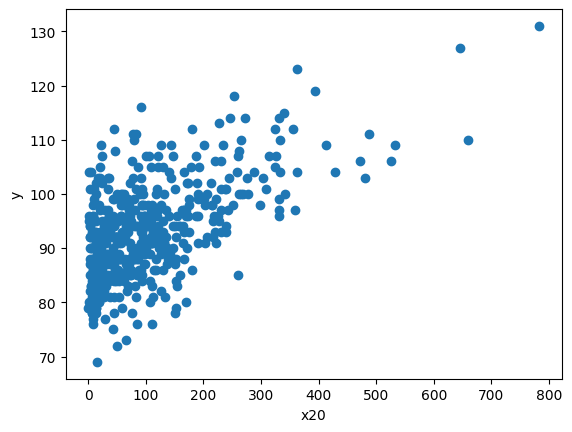

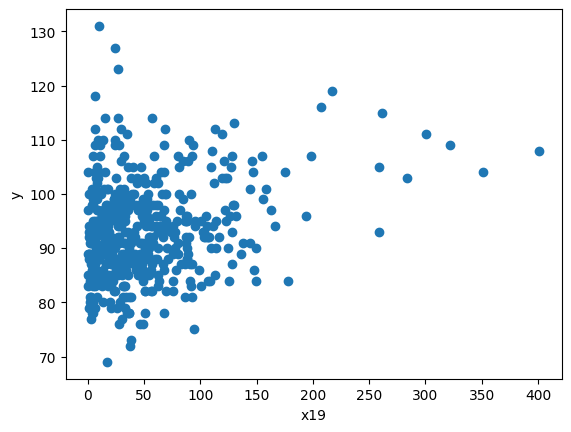

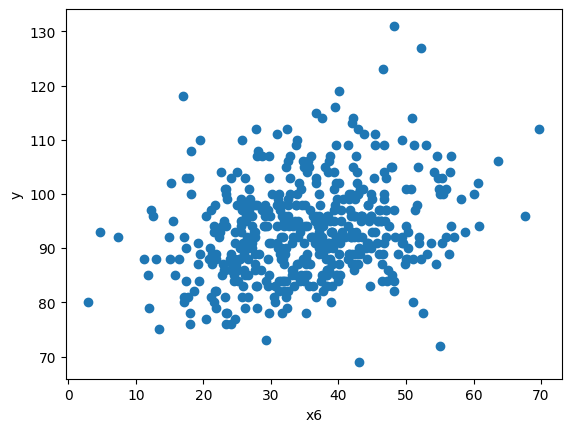

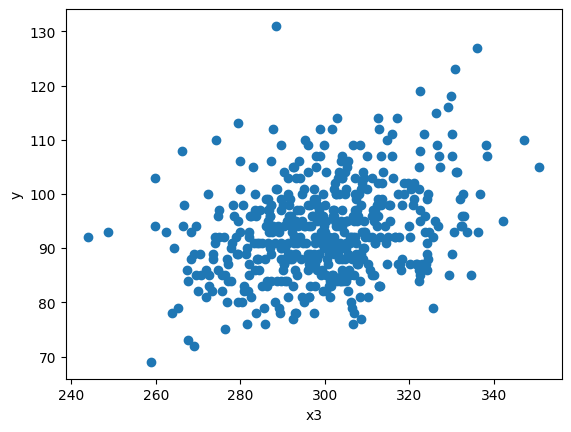

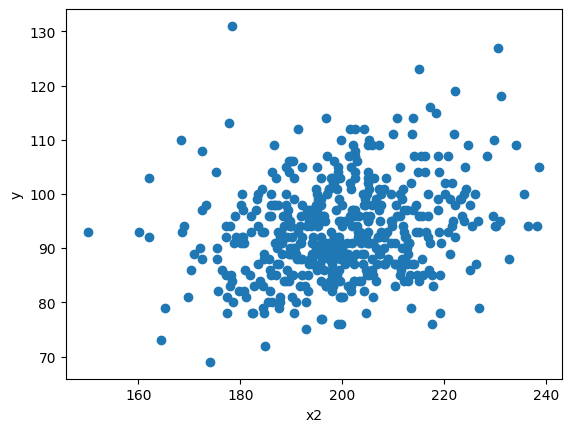

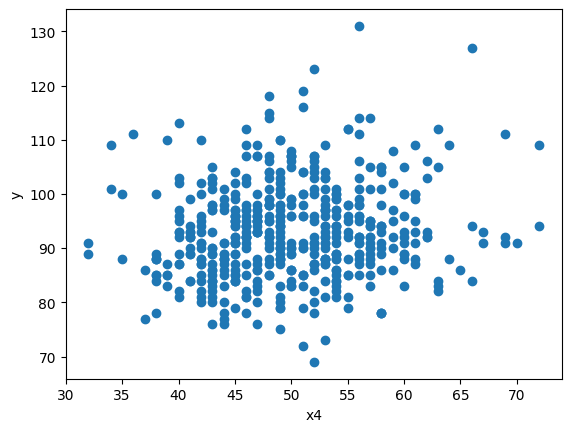

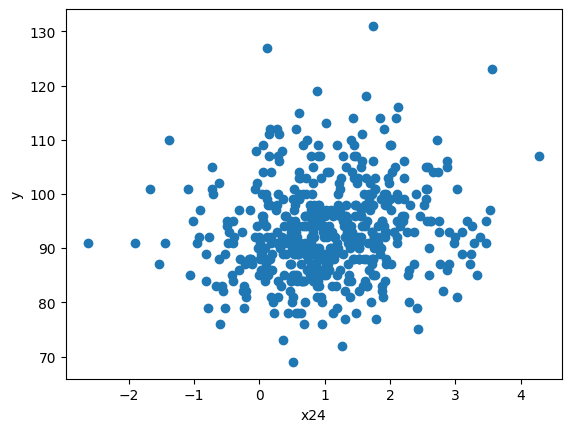

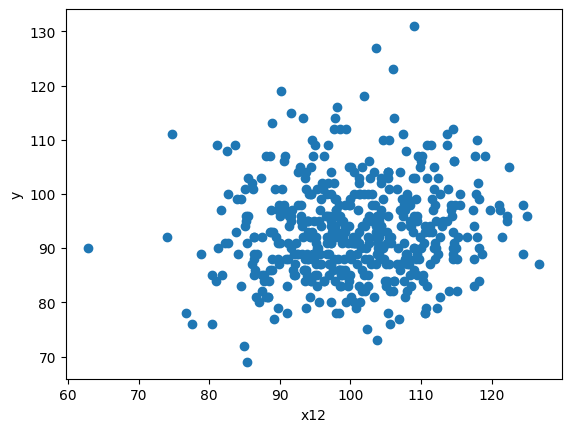

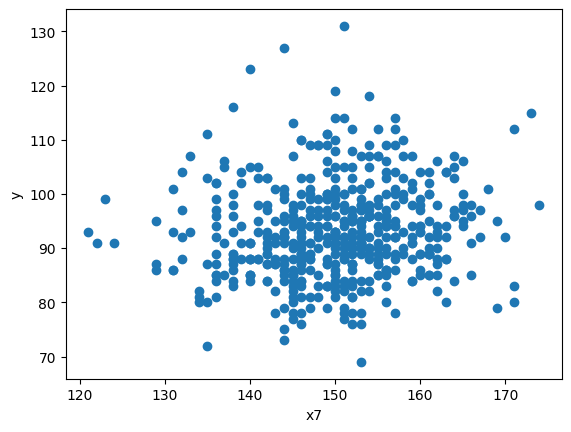

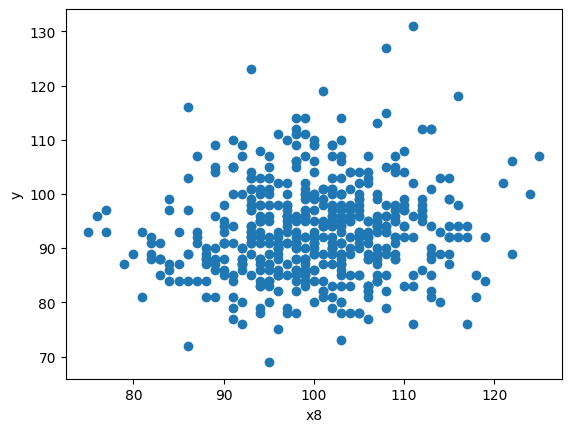

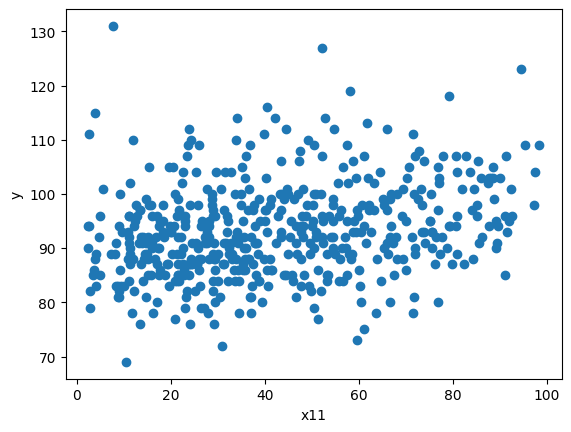

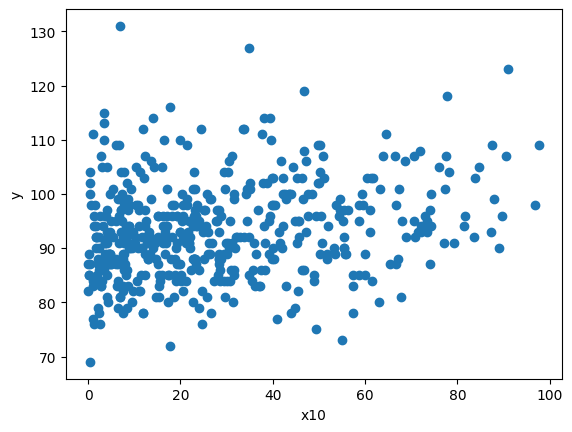

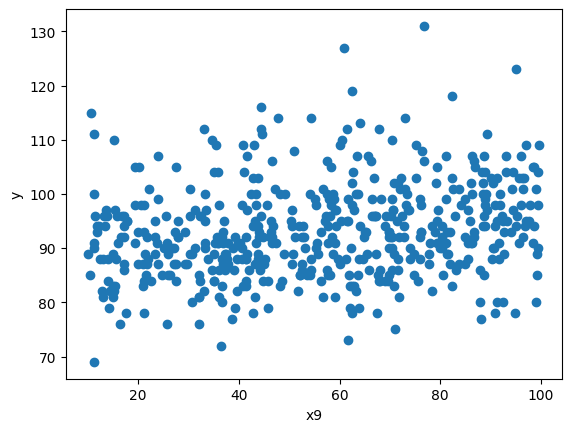

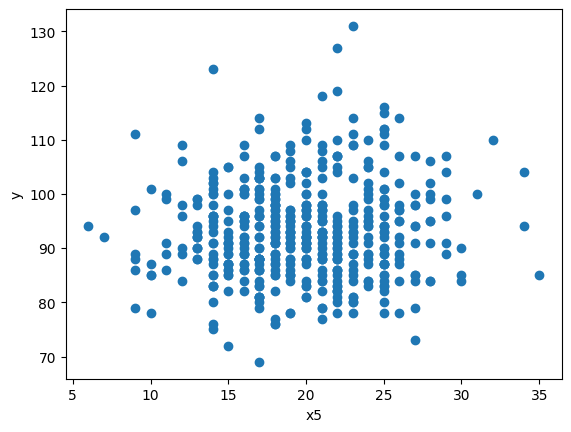

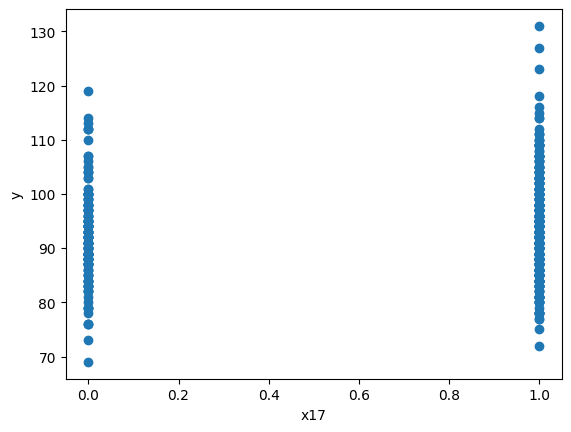

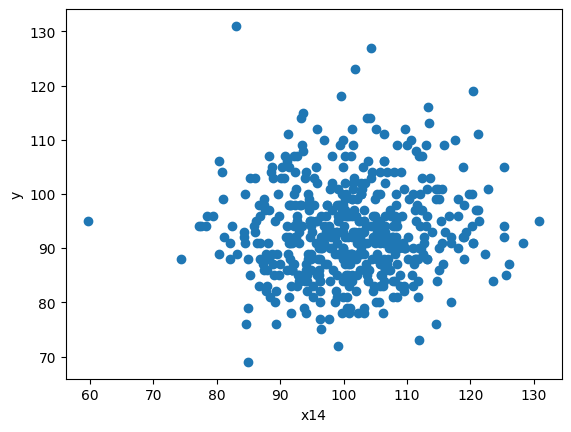

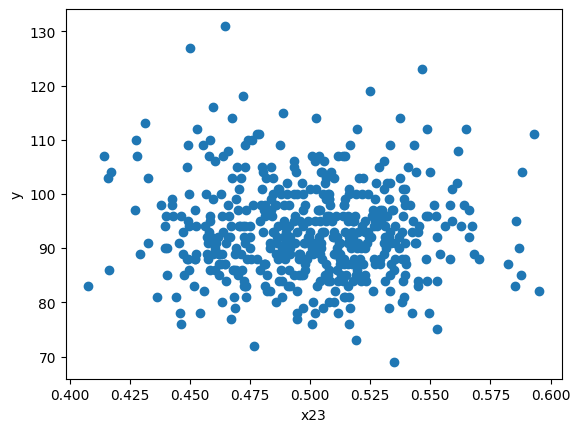

In [7]:
# Plot the columns that were removed
for col in res[0]:
    plt.scatter(df[col], y)
    plt.xlabel(col)
    plt.ylabel(df.columns[0])
    plt.show()

In [8]:
print("push")

push
